# Machine Learning mini-project

## Understanding Classification and Regression (12 points)

### Classification

Describe a classification problem in chemical, biochemical, or environmental engineering (that is not related to drug discovery, since we've explored that in class). Specify the label of interest, and list at least 2 features that may be relevant for classification. If relevant, provide the units of the variables.

**<font color=blue>0 / 6 points</font>**

Describe the problem: Hardness is a measure used in water quality to see if the water will cause scum to form or if it will lather well. The problem is that there is carbonate hardness and noncarbonate hardness which also need to be classified with total hardness, and treated differently to soften the water. 

Label: Hardness (mg/L as CaCO3): extremely soft, very soft, soft to moderately hard, hard, very hard

Features: concentration of Ca2+ (mg/L), concentration of Mg2+ (mg/L), alkalinity (mg/L as CaCO3)

### Regression

Describe a regression problem in chemical, biochemical, or environmental engineering (that is not related to thermodynamic properties, since we've covered that in class). Specify the label of interest, and list at least 2 features that may be relevant for regression. Also provide the units of the variables, if relevant.

**<font color=blue>0 / 6 points</font>**

Describe the problem:

Label:

Features:

**Use the cell below to import any libraries you need for this notebook**

In [228]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.linear_model import LogisticRegression
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.Chem import rdFingerprintGenerator

## Part 1: The white wine dataset (45 points)

### Reading and sorting the dataset (5 points)

**<font color=blue>0 / 5 points</font>** Read in the **white** wine quality dataset (find it in the datasets folder on Blackboard), sort it by residual sugar and then by alcohol content, and re-index the rows, so the sorted dataframe goes from 0 to max

In [133]:
#read the white wine quality csv, note the provided csv from class had an error in it. If it hasnt been fixed yet
#then open up the csv and find and replace all of the ; with , and it should work.
wine = pd.read_csv('winequality-white.csv')

#first use sort values to arrange by sugar and then alcohol and afterwards re index the frame to leave it in this order
wine = wine.sort_values(by=['residual sugar','alcohol']).reset_index(drop=True) #drop = True gets rid of the old index
wine.tail(10)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
4888,6.9,0.240,0.36,20.80,0.031,40.0,139.0,0.99750,3.20,0.33,11.0,6
4889,6.8,0.280,0.40,22.00,0.048,48.0,167.0,1.00100,2.93,0.50,8.7,5
4890,6.8,0.280,0.40,22.00,0.048,48.0,167.0,1.00100,2.93,0.50,8.7,5
4891,5.9,0.220,0.45,22.60,0.120,55.0,122.0,0.99636,3.10,0.35,12.8,5
4892,6.9,0.270,0.49,23.50,0.057,59.0,235.0,1.00240,2.98,0.47,8.6,5
4893,6.8,0.450,0.28,26.05,0.031,27.0,122.0,1.00295,3.06,0.42,10.6,6
4894,6.8,0.450,0.28,26.05,0.031,27.0,122.0,1.00295,3.06,0.42,10.6,6
4895,7.9,0.330,0.28,31.60,0.053,35.0,176.0,1.01030,3.15,0.38,8.8,6
4896,7.9,0.330,0.28,31.60,0.053,35.0,176.0,1.01030,3.15,0.38,8.8,6
4897,7.8,0.965,0.60,65.80,0.074,8.0,160.0,1.03898,3.39,0.69,11.7,6


### Categorizing wines and analyzing their properties (10 points)

The LCBO sugar code categorizes wine as dry if it has less than 2% residual sugar, medium (or semi-dry or semi-sweet) if it has between 2 and 7% residual sugar, and sweet if it has >7% residual sugar. 

**<font color=blue>0 / 5 points</font>** Categorize each wine according to its sweetness, and add its category to the dataframe. If you can't figure out how to add the categories to the dataframe, partial credit will be given for creating separate dataframes for each category. Hint: I found [this page](https://datatofish.com/if-condition-in-pandas-dataframe/) to have helpful tips. Finally, what fraction of the wines are in each category?

In [134]:
#add category column, use list comprehension to define category based on residual sugar
wine['category'] = ['sweet' if x >7 else 'semi-sweet' if  x >=2 else 'dry' for x in wine['residual sugar']]
print('Wines in sweet category: ',wine.category.value_counts()[0],'/',wine.category.count(),'\n'
      'Wines in semi-sweet category: ',wine.category.value_counts()[1],'/',wine.category.count(),'\n'
      'Wines in dry category: ',wine.category.value_counts()[2],'/',wine.category.count(),'\n')

Wines in sweet category:  1955 / 4898 
Wines in semi-sweet category:  1522 / 4898 
Wines in dry category:  1421 / 4898 



**<font color=blue>0 / 5 points</font>** When wine is fermented, sugar is converted into alcohol. We might therefore expect that high-alcohol wines have less sugar. Do you observe this trend across the whole dataset? What about within each category (for example, among dry wines, do high-alcohol wines have less sugar)? No need to perform regression for this question; plotting the data and describing what you see is sufficient.

Text(0.5, 1.0, 'sugar and alcohol for dry wines')

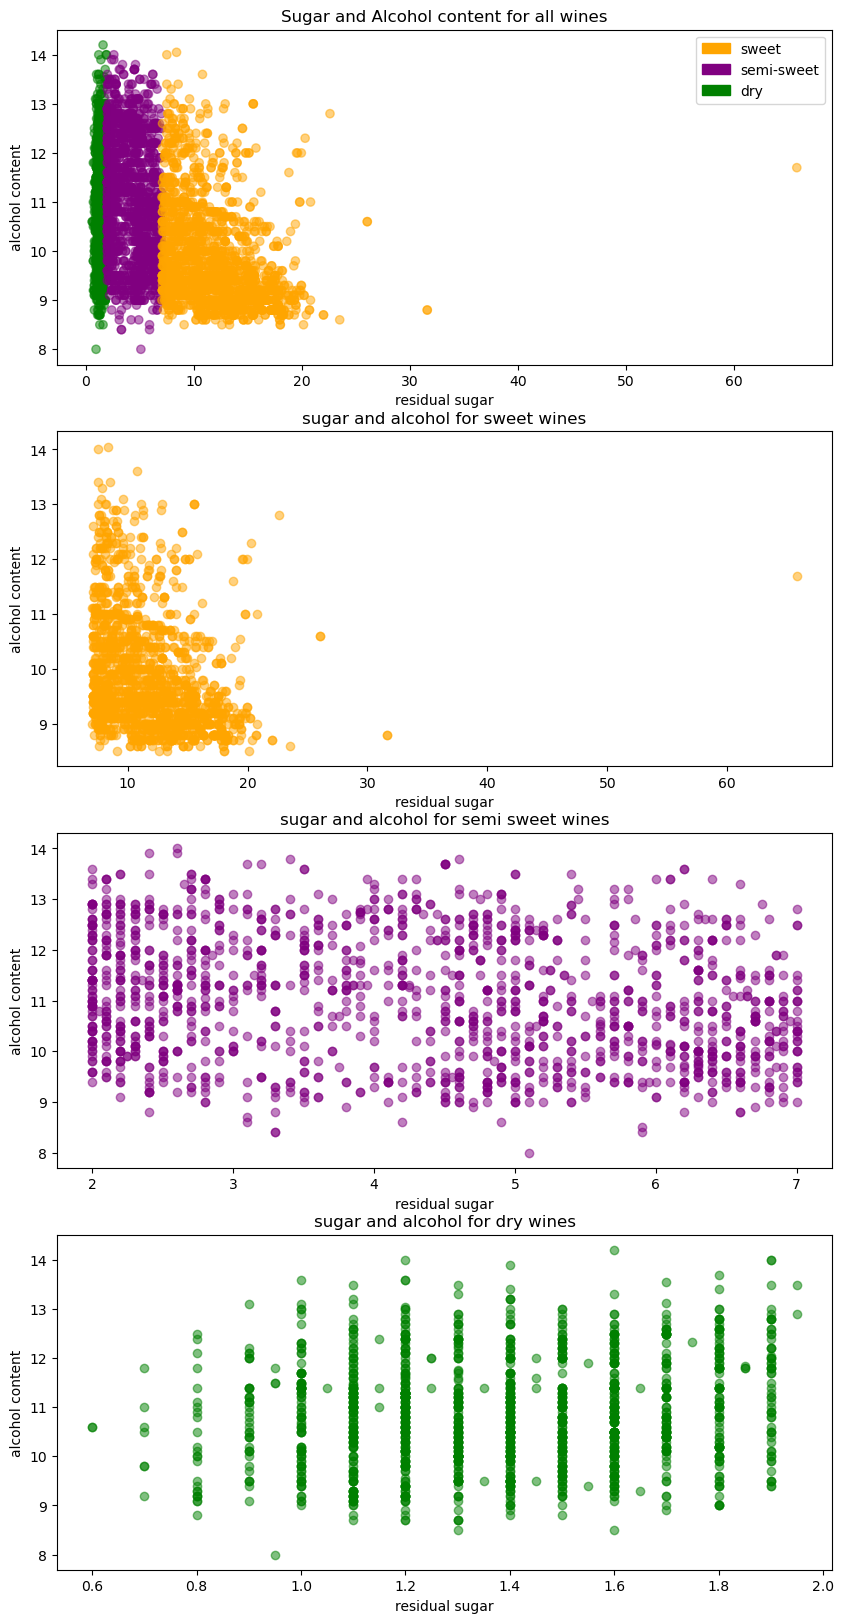

In [135]:
#dict to hold what colors to use based on sweetness
colors = {'sweet':'orange','semi-sweet':'purple','dry':'green'}

#create masks that will be used to select from sweetness categories
sweetMask = wine.category == 'sweet'
semiSweetMask = wine.category == 'semi-sweet'
dryMask = wine.category == 'dry'

#define all the plots I need
fig, ax = plt.subplots(4,figsize = (10,20))

ax[0].scatter(x = wine['residual sugar'],y=wine.alcohol,c=wine.category.map(colors),alpha = .5)
ax[0].set_xlabel('residual sugar')
ax[0].set_ylabel('alcohol content')
ax[0].set_title('Sugar and Alcohol content for all wines')
#utilizing patches to make sure legend is correct
dry_patch = mpatches.Patch(color=colors['dry'], label='dry')
semiSweet_patch = mpatches.Patch(color=colors['semi-sweet'], label='semi-sweet')
sweet_patch = mpatches.Patch(color=colors['sweet'], label='sweet')
ax[0].legend(handles=[sweet_patch,semiSweet_patch,dry_patch])

#plot the sweet wines only
ax[1].scatter(x = wine[sweetMask]['residual sugar'],y=wine[sweetMask].alcohol,c=colors['sweet'],alpha = .5)
ax[1].set_xlabel('residual sugar')
ax[1].set_ylabel('alcohol content')
ax[1].set_title('sugar and alcohol for sweet wines')

#plot the semi sweet wines
ax[2].scatter(x = wine[semiSweetMask]['residual sugar'],y=wine[semiSweetMask].alcohol,c=colors['semi-sweet'],alpha = .5)
ax[2].set_xlabel('residual sugar')
ax[2].set_ylabel('alcohol content')
ax[2].set_title('sugar and alcohol for semi sweet wines')

#plot the dry wines
ax[3].scatter(x = wine[dryMask]['residual sugar'],y=wine[dryMask].alcohol,c=colors['dry'],alpha = .5)
ax[3].set_xlabel('residual sugar')
ax[3].set_ylabel('alcohol content')
ax[3].set_title('sugar and alcohol for dry wines')


There does not seem to be much correlation between residual sugar and alcohol content, many different alcohol contents exist at most sugar levels. There may be a small possitive correlation with sugar and alochol for dry wines and possibly a small negative correlation in the semi-sweet wines but they do not appear to be significant even if they exist

### Predicting wine quality (30 points)

**<font color=blue>0 / 5 points</font>** Normalize the data to give a mean of zero and a standard deviation of 1. Divide the dataset into training and test sets, with 30% of the data in the test set.

In [136]:
#get a list of columns for use in normalizing data
cols = wine.columns
#drop category as it does not have a std or mean to normalize
cols = cols.drop('category')
#normalize data
wineNorm = (wine[cols] - wine[cols].mean())/wine[cols].std()
#add category back
wineNorm['category'] = wine.category

#split train and test data
X_train, X_test, y_train, y_test = train_test_split(wineNorm.drop(columns=['quality','category']),
                                                    wineNorm['quality'], test_size=0.30, random_state=0)


**<font color=blue>0 / 5 points</font>** Fit a model to predict wine quality using linear regression, and report the RMSE of the training and test sets. Make a parity plot showing the accuracy of your predictions in the training and test sets. (Report quality in original units; minus 1 point if reported in normalized units)

Training root mean squared error: 0.76
Test root mean squared error: 0.72


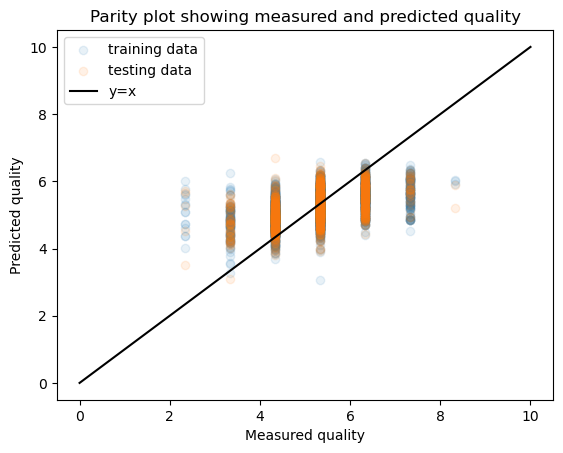

In [137]:
# Create linear regression object
regr = LinearRegression()

# Fit the model
regr.fit(X_train,y_train)

pred_train = regr.predict(X_train) # X is the argument for regr.predict()
pred_test = regr.predict(X_test)

#unnormalize the quality data
pred_train_unNorm = (pred_train + wine.quality.mean())*wine.quality.std()
pred_test_unNorm = (pred_test + wine.quality.mean())*wine.quality.std()
y_train_unNorm = (y_train + wine.quality.mean())*wine.quality.std()
y_test_unNorm = (y_test + wine.quality.mean())*wine.quality.std()

# The root mean squared error
print('Training root mean squared error: %.2f'
      % mean_squared_error(y_train_unNorm,pred_train_unNorm,squared=False))
print('Test root mean squared error: %.2f'
      % mean_squared_error(y_test_unNorm,pred_test_unNorm,squared=False))

fig, ax = plt.subplots()

#creating a parity plot
ax.scatter(y_train_unNorm,pred_train_unNorm,alpha=0.1,label='training data')
ax.scatter(y_test_unNorm,pred_test_unNorm,alpha=0.1,label='testing data')
ax.plot(np.linspace(0,10,10),np.linspace(0, 10,10),'k-',label='y=x') # This will give us a diagonal line
ax.set_xlabel('Measured quality')
ax.set_ylabel('Predicted quality')
ax.set_title('Parity plot showing measured and predicted quality')
ax.legend()


**<font color=blue>0 / 5 points</font>** Fit a model to predict wine quality using LASSO regression, adjusting the value of alpha until you have 4 nonzero coefficients remaining. Report the normalized RMSE for the test set and the training set.

In [138]:
# Create Lasso regression object
lasso_regr = Lasso(alpha=0.078) # specify the scaling parameter alpha

# Fit the model
lasso_regr.fit(X_train, y_train)

# Take a look at the coefficients
print('lasso coeficents are: ')
for i in range(0,len(lasso_regr.coef_)):
    print(lasso_regr.coef_[i])

pred_train_lasso = lasso_regr.predict(X_train) # X is the argument for regr.predict()
pred_test_lasso = lasso_regr.predict(X_test)

# The root mean squared error
print('Training root mean squared error: %.2f'
      % mean_squared_error(y_train,pred_train_lasso,squared=False))
print('Test root mean squared error: %.2f'
      % mean_squared_error(y_test,pred_test_lasso,squared=False))# The root mean squared error


lasso coeficents are: 
-0.0023465718550452546
-0.12718254464712753
-0.0
0.002252895690161358
-0.0
0.0
-0.0
-0.0
0.0
0.0
0.3807832744604573
Training root mean squared error: 0.89
Test root mean squared error: 0.85


**<font color=blue>0 / 10 points</font>** Fit three models to predict wine quality using LASSO regression, one model for each category of wine (sweet, semi-sweet, dry), and report the RMSE for the training and test set for each category. Are some types of wine easier to predict than other types? Are the same factors important across all categories, or is quality among dry white wines characterized by different features compared to quality among sweet wines?

In [139]:
#defining seperate data frames holding the corresponding wines for ease of use in code
sweetWines = wineNorm[sweetMask]
semiSweetWines = wineNorm[semiSweetMask]
dryWines = wineNorm[dryMask]

#fitting a model for sweet Wines
#split train and test data
X_train_sweet, X_test_sweet, y_train_sweet, y_test_sweet = train_test_split(sweetWines.drop(columns=['quality','category']),
                                                    sweetWines['quality'], test_size=0.30, random_state=0)
# Create Lasso regression object
lasso_regr_sweet = Lasso(alpha=.035) # specify the scaling parameter alpha

# Fit the model
lasso_regr_sweet.fit(X_train_sweet, y_train_sweet)

# Take a look at the coefficients
print('lasso coeficents for sweet wines are: ')
for i in range(0,len(lasso_regr_sweet.coef_)):
    print(lasso_regr_sweet.coef_[i])
#use model to make predictions
pred_train_sweet_lasso = lasso_regr.predict(X_train_sweet) 
pred_test_sweet_lasso = lasso_regr.predict(X_test_sweet)

# The root mean squared error
print('Training root mean squared error in the sweet wines is: %.2f'
      % mean_squared_error(y_train_sweet,pred_train_sweet_lasso,squared=False))
print('Test root mean squared error in the sweet wines is: %.2f'
      % mean_squared_error(y_test_sweet,pred_test_sweet_lasso,squared=False))# The root mean squared error

#fitting a model for semi-sweet Wines
#split train and test data
X_train_sSweet, X_test_sSweet, y_train_sSweet, y_test_sSweet = train_test_split(semiSweetWines.drop(columns=['quality','category']),
                                                    semiSweetWines['quality'], test_size=0.30, random_state=0)
# Create Lasso regression object
lasso_regr_sSweet = Lasso(alpha=.07) # specify the scaling parameter alpha

# Fit the model
lasso_regr_sSweet.fit(X_train_sSweet, y_train_sSweet)

# Take a look at the coefficients
print('\nlasso coeficents for semi-sweet wines are: ')
for i in range(0,len(lasso_regr_sSweet.coef_)):
    print(lasso_regr_sSweet.coef_[i])
#use model to make predictions
pred_train_sSweet_lasso = lasso_regr.predict(X_train_sSweet) 
pred_test_sSweet_lasso = lasso_regr.predict(X_test_sSweet)

# The root mean squared error
print('Training root mean squared error in the semi-sweet wines is: %.2f'
      % mean_squared_error(y_train_sSweet,pred_train_sSweet_lasso,squared=False))
print('Test root mean squared error in the semi-sweet wines is: %.2f'
      % mean_squared_error(y_test_sSweet,pred_test_sSweet_lasso,squared=False))# The root mean squared error

#fitting a model for dry Wines
#split train and test data
X_train_dry, X_test_dry, y_train_dry, y_test_dry = train_test_split(dryWines.drop(columns=['quality','category']),
                                                    dryWines['quality'], test_size=0.30, random_state=0)
# Create Lasso regression object
lasso_regr_dry = Lasso(alpha=.18) # specify the scaling parameter alpha

# Fit the model
lasso_regr_dry.fit(X_train_dry, y_train_dry)

# Take a look at the coefficients
print('\nlasso coeficents for dry wines are: ')
for i in range(0,len(lasso_regr_dry.coef_)):
    print(lasso_regr_dry.coef_[i])
#use model to make predictions
pred_train_dry_lasso = lasso_regr.predict(X_train_dry) 
pred_test_dry_lasso = lasso_regr.predict(X_test_dry)

# The root mean squared error
print('Training root mean squared error in the dry wines is: %.2f'
      % mean_squared_error(y_train_dry,pred_train_dry_lasso,squared=False))
print('Test root mean squared error in the dry wines is: %.2f'
      % mean_squared_error(y_test_dry,pred_test_dry_lasso,squared=False))# The root mean squared error


lasso coeficents for sweet wines are: 
-0.0
-0.23064508732259661
-0.0
0.0
-0.03627980219878148
-0.0
-0.001165778387225977
-0.0
-0.0
0.0
0.325132607220152
Training root mean squared error in the sweet wines is: 0.84
Test root mean squared error in the sweet wines is: 0.84

lasso coeficents for semi-sweet wines are: 
-0.003590595133392634
-0.0687400422669249
-0.0
-0.0
-0.0
0.057705542191976086
-0.0
-0.0
0.0
-0.0
0.47957646261109527
Training root mean squared error in the semi-sweet wines is: 0.88
Test root mean squared error in the semi-sweet wines is: 0.92

lasso coeficents for dry wines are: 
-0.0
-0.08155387904862635
0.0
0.0
-0.0
0.005582450674167997
-0.0
-0.0
0.0
0.02327339077878502
0.24066955751002247
Training root mean squared error in the dry wines is: 0.91
Test root mean squared error in the dry wines is: 0.93


### Discussion / results from above
Sweet wines are the easiest to predict having the lowest RMSE and equal error in training and testing set, however it is not so much lower than the other that it can be said they are 'easy' to predict <br>

all of the wines had different sets of important factors however 2 items were consistently important for all categories of wine<br> these were the alcohol content and the volatile acidity

**<font color=blue>0 / 5 points</font>** Display these predictions in two side-by-side parity plots (using matplotlib or plotly; it's your choice). In one parity plot, show the prediction vs. experiment using the whole data set and one set of fitted coefficients, while coloring the points according to their category, and changing the marker style according to test or training set. In the other parity plot, show the prediction vs. experiment using where the predictions come from the three separate models, still coloring the points according to their category, and changing the marker style according to test or training set.

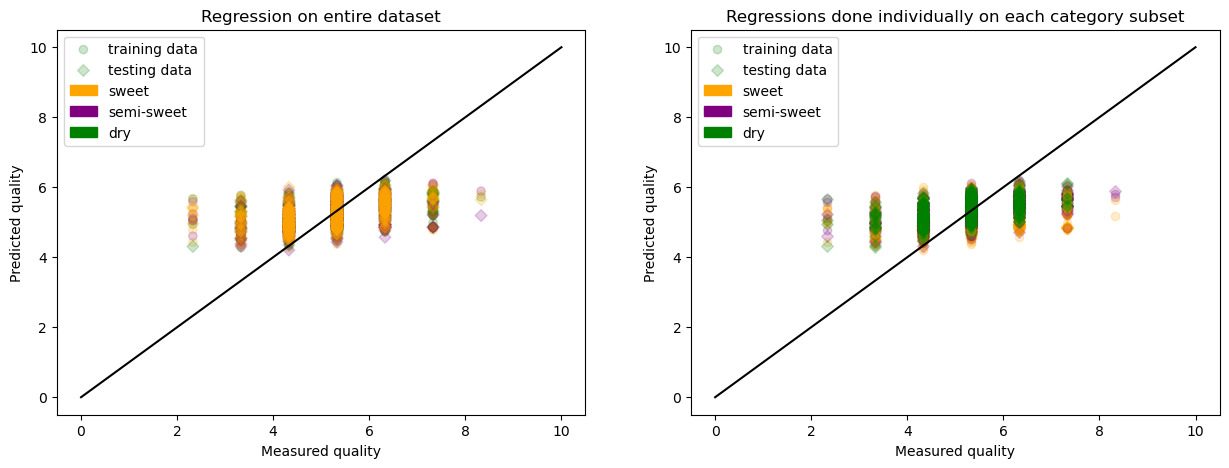

In [147]:
#unNormalize the data for the sweet, semisweet, and dry regressions lasso
y_train_sweet_uN = (y_train_sweet + wine.quality.mean())*wine.quality.std()
y_test_sweet_uN = (y_test_sweet + wine.quality.mean())*wine.quality.std()
pred_train_sweet_lasso_uN  = (pred_train_sweet_lasso + wine.quality.mean())*wine.quality.std()
pred_test_sweet_lasso_uN = (pred_test_sweet_lasso + wine.quality.mean())*wine.quality.std()

y_train_sSweet_uN = (y_train_sSweet + wine.quality.mean())*wine.quality.std()
y_test_sSweet_uN = (y_test_sSweet + wine.quality.mean())*wine.quality.std()
pred_train_sSweet_lasso_uN  = (pred_train_sSweet_lasso + wine.quality.mean())*wine.quality.std()
pred_test_sSweet_lasso_uN = (pred_test_sSweet_lasso + wine.quality.mean())*wine.quality.std()

y_train_dry_uN = (y_train_dry + wine.quality.mean())*wine.quality.std()
y_test_dry_uN = (y_test_dry + wine.quality.mean())*wine.quality.std()
pred_train_dry_lasso_uN  = (pred_train_dry_lasso + wine.quality.mean())*wine.quality.std()
pred_test_dry_lasso_uN = (pred_test_dry_lasso + wine.quality.mean())*wine.quality.std()

pred_train_lasso_uN = (pred_train_lasso + wine.quality.mean())*wine.quality.std()
pred_test_lasso_uN = (pred_test_lasso + wine.quality.mean())*wine.quality.std()
#mask for color mapping
cmask = wine.index.isin(X_train.index)
cmask2 = wine.index.isin(X_test.index)
#legend handles for colors
colorHandles = [sweet_patch,semiSweet_patch,dry_patch]
#make the plots
fig, ax = plt.subplots(1,2,figsize=(15,5))
#these two are defined as variables to help get the correct handles for the graph legends
#use the 'o' marker style ofr training data and the 'D' marker style for test data
#use the colors that were defined for each category earlier
train = ax[0].scatter(y_train_unNorm,pred_train_lasso_uN,alpha=0.2,label='training data',marker='o',c=wine[cmask].category.map(colors))
test = ax[0].scatter(y_test_unNorm,pred_test_lasso_uN,alpha=0.2,label='testing data',marker='D',c=wine[cmask2].category.map(colors))

ax[0].plot(np.linspace(0,10,10),np.linspace(0, 10,10),'k-',label='y=x') # This will give us a diagonal line
ax[0].set_xlabel('Measured quality')
ax[0].set_ylabel('Predicted quality')
ax[0].set_title('Regression on entire dataset')
ax[0].legend(handles = [train,test]+colorHandles)

#creating the plot using the values from the 3 seperate category regressions
ax[1].scatter(y_train_sweet_uN,pred_train_sweet_lasso_uN,alpha=0.2,marker='o',c=colors['sweet'])
ax[1].scatter(y_test_sweet_uN,pred_test_sweet_lasso_uN,alpha=0.2,marker='D',c=colors['sweet'])

ax[1].scatter(y_train_sSweet_uN,pred_train_sSweet_lasso_uN,alpha=0.2,marker='o',c=colors['semi-sweet'])
ax[1].scatter(y_test_sSweet_uN,pred_test_sSweet_lasso_uN,alpha=0.2,marker='D',c=colors['semi-sweet'])

ax[1].scatter(y_train_dry_uN,pred_train_dry_lasso_uN,alpha=0.2,marker='o',c=colors['sweet'])
ax[1].scatter(y_test_dry_uN,pred_test_dry_lasso_uN,alpha=0.2,marker='D',c=colors['dry'])

ax[1].plot(np.linspace(0,10,10),np.linspace(0, 10,10),'k-',label='y=x') # This will give us a diagonal line
ax[1].set_xlabel('Measured quality')
ax[1].set_ylabel('Predicted quality')
ax[1].set_title('Regressions done individually on each category subset')
ax[1].legend(handles = [train,test]+colorHandles)


## Part 2: EFGR Inhibitor Classification (43 points)

### Loading and visualizing molecules (3 points)

**<font color=blue>0 / 3 points</font>** Load the .csv files for the active and inactive EFGR inhibitors into a DataFrame, and create lists of molecule objects for each. Display in a grid 5 molecules from each set. 

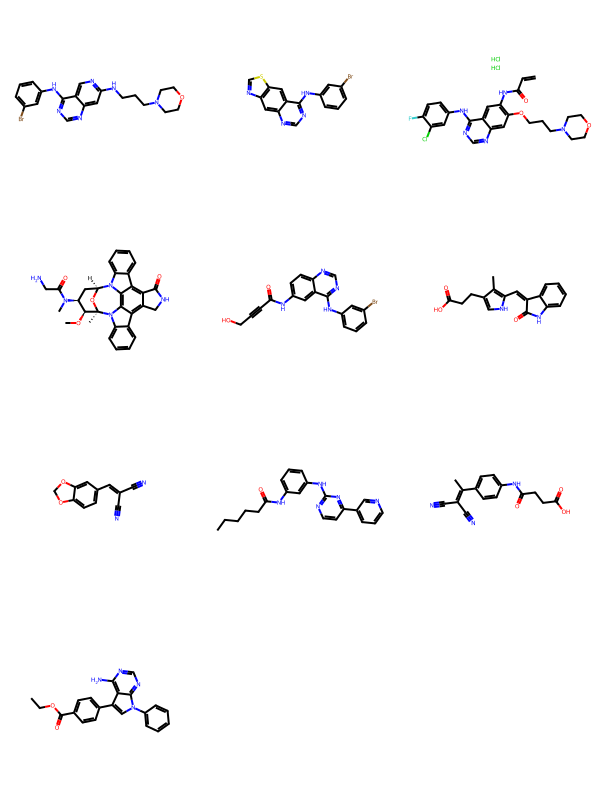

In [201]:
#load the actives and inactives into seperate frames and add the active/inactive categorys
actives = pd.read_csv('Chembl_EGFR_actives_ML.csv')
actives['category'] = 'active'

inactives = pd.read_csv('Chembl_EGFR_inactives_ML.csv')
inactives['category']='inactive'
#concatanate the frames together
chems = pd.concat([actives,inactives])
#add an rdkit chem molecule to the frame for each item
chems['molecule']= chems.canonical_smiles.apply(lambda x: Chem.MolFromSmiles(x))

#masks to select only active or inactive molecuels
activeMask = chems.category == 'active'
inactiveMask = chems.category == 'inactive'
#assign a value of 1 to active and 0 to inactive as a numerical category
chems['numCat'] = chems['category'].apply(lambda x: 0 if x == 'inactive' else 1)
#make a list of 5 random active and inactive molecules
molList = list(chems[activeMask].sample(5).molecule[:])+list(chems[inactiveMask].sample(5).molecule[:])
#draw the list to the grid
Draw.MolsToGridImage(molList, useSVG=True)

### Classification using global descriptors (10 points)

**<font color=blue>0 / 5 points</font>** Use RDKit to calculate the values of at least 5 global descriptors (such as heavy atom count, LogP, etc.). Add these values to the DataFrame from the previous problem. 

In [216]:
#utilizing pandas apply method and the lambda function we can easily add columns for different descriptors
chems['heavyAtoms'] = chems.molecule.apply(lambda x: Descriptors.HeavyAtomCount(x))
chems['numHDonors'] = chems.molecule.apply(lambda x: Descriptors.NumHDonors(x))
chems['numHAcceptors'] = chems.molecule.apply(lambda x: Descriptors.NumHAcceptors(x))
chems['molWt'] = chems.molecule.apply(lambda x: Descriptors.MolWt(x))
chems['molLogP'] = chems.molecule.apply(lambda x: Descriptors.MolLogP(x))

,canonical_smiles,molecule_chembl_id,category,molecule,numCat,heavyAtoms,numHDonors,numHAcceptors,molWt,molLogP
0,COc1ccc(NC(=O)c2ccc(cc2)N(CCCl)CCCl)cc1,CHEMBL589588,active,<rdkit.Chem.rdchem.Mol object at 0x15037de40>,1,24,1,3,367.276,4.2315
1,N(c1ccc2[nH]ccc2c1)c3ncnc4cc(sc34)c5ccccc5,CHEMBL76432,active,<rdkit.Chem.rdchem.Mol object at 0x15037df20>,1,25,2,4,342.427,5.5832
2,CS(=O)(=O)CCNCCCCOc1ccc2ncnc(Nc3ccc(F)c(Cl)c3)...,CHEMBL460731,active,<rdkit.Chem.rdchem.Mol object at 0x15037df90>,1,31,2,7,466.966,3.9591
3,NC(=O)C1CCN(Cc2ccc(cc2)c3cc4nccc(Nc5ccc6[nH]cc...,CHEMBL431977,active,<rdkit.Chem.rdchem.Mol object at 0x15037deb0>,1,35,3,5,481.625,5.8855
4,CC(C)(CO)NCc1ccc(cc1)c2cc3ncnc(Nc4ccc5[nH]ccc5...,CHEMBL308498,active,<rdkit.Chem.rdchem.Mol object at 0x15037ddd0>,1,32,4,6,443.576,5.4437


**<font color=blue>0 / 5 points</font>** Using these global descriptors as your features, fit a classification model to predict activity. Put 20% of the molecules in the test set (when you do this, please use `train_test_split` and set random=0), and report the accuracy of the model. How accurate is this model on the training set? On the test set?

In [226]:
#making a smaller dataframe so I can see everything on the screen and only contain the items i need for regression and identification
shortChems = chems.drop(columns=['canonical_smiles','molecule_chembl_id','category','molecule'])
#split the data
X_train, X_test, y_train, y_test = train_test_split(shortChems.drop(columns='numCat'),
                                                    shortChems['numCat'], test_size=0.20, random_state=0)


# Create the classifier object
clf = LogisticRegression(random_state=0)

# Fit the classifier object
clf.fit(X_train,y_train)

#predict the data
predTest = clf.predict(X_test)
predTrain = clf.predict(X_train)

#look at the scores
testScore = clf.score(X_test,y_test)
trainScore = clf.score(X_train,y_train)
print('Test score: ',testScore,'\nTrain Score: ',trainScore)


Test score:  0.65 
Train Score:  0.69375


### Discussing results

The model based on these 5 descriptors is not very accurate, it was only able to correctly determine the category 65% of the time on the test set and only 70% of the time in the training set.

### Classification using Morgan fingerprints (30 points)

**<font color=blue>0 / 5 points</font>** Calculate Morgan fingerprints of radius 2 for each molecule, and fit a classification model using the fingerprints as your features (put 20% of the molecules in the test set). Report the accuracy of the model on the training set and test set. (This question closely resembles what we did in Lecture 15 Notebook)

In [248]:
#generate a fingerprints column, however I had issues getting this column to work correctly when fitting the model
chems['fps'] = chems.molecule.apply(lambda x: rdFingerprintGenerator.GetFPs([x]))

#exporting the molecules to a list and generating the fingerprints this way worked easier to get the model to fit correctly
mols = chems.molecule.to_list()
fps = rdFingerprintGenerator.GetFPs(mols)

#making a list of the y values to put into the model
y = fpChems.numCat.to_list()

#split the data
X_train, X_test, y_train, y_test = train_test_split(fps,y, test_size=0.20, random_state=0)


# Create the classifier object
clf = LogisticRegression(random_state=0)

# Fit the classifier object
clf.fit(X_train,y_train)

#predict the data
predTest = clf.predict(X_test)
predTrain = clf.predict(X_train)

#look at the scores
testScore = clf.score(X_test,y_test)
trainScore = clf.score(X_train,y_train)
print('Test score: ',testScore,'\nTrain Score: ',trainScore)


Test score:  0.925 
Train Score:  0.99375


**<font color=blue> 0 / 10 points </font>** Examine the Tanimoto similarity of the active and inactive molecules to each of the 5 FDA-approved molecules using the fingerprints. Think of a way to visualize this, and share your findings.

**<font color=blue> 0 / 10 points </font>** Take a look at the classification coefficients. Which molecular fingerprint features have the most positive weights, and which have the most negative weights? How many molecules in the active set and the inactive set have the feature with the highest positive weight? How many molecules in the active set and inactive set have the feature with the lowest negative weight? 

**<font color=blue> 0 / 5 points </font>** For the feature with the largest positive weight, find a molecule in the active set with that fragment, and visualize the fingerprint fragment. For the feature with the most negative weight, find a molecule in the inactive set with that fragment, and visualize the fingerprint fragment.